In [444]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [445]:
import pandas as pd

df = pd.read_csv('/content/gdrive/My Drive/digits_with_angle.csv')
df.describe()

,evtId,ipad,itime,amp,crossing_angle,dip_angle
count,200027.000000,200027.000000,200027.000000,200027.000000,200027.000000,2.000270e+05
mean,4994.392512,43.285206,270.366086,261.699776,7.656981,1.694100e+01
std,2881.009559,1.171099,1.450436,610.276657,4.324842,7.244001e-11
min,0.000000,40.000000,267.000000,1.000000,0.006000,1.694100e+01
25%,2504.000000,42.000000,269.000000,18.930000,3.932000,1.694100e+01
50%,5000.000000,43.000000,270.000000,106.500000,7.758000,1.694100e+01
75%,7486.000000,44.000000,272.000000,325.800000,11.380000,1.694100e+01
max,9981.000000,46.000000,274.000000,38930.000000,14.999000,1.694100e+01


In [0]:
df['ipad'] -= df.min()['ipad']
df['itime'] -= df.min()['itime']

In [0]:
import numpy as np

from scipy.sparse import csr_matrix

data = np.array(df)
data = np.array([data[data[:, 0] == k] for k in np.unique(data[:, 0])])
images = []
angles = []

for i in range(0, data.shape[0]):
  row = np.array(data[i][:, 1])
  col = np.array(data[i][:, 2])
  amp = np.log(np.array(data[i][:, 3]))
  images.append(csr_matrix((amp, (row, col)), shape=(8, 8)).toarray())
  angles.append(data[i][:, 4][0])

images = np.expand_dims(images, axis=3)
angles = np.array(angles)

In [448]:
images.shape, angles.shape

((9982, 8, 8, 1), (9982,))

In [449]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

'2.2.0'

In [450]:
from tensorflow.keras.models import load_model

generator = load_model('/content/gdrive/My Drive/parameterize_03.h5')
# generator = load_model('/content/gdrive/My Drive/generator_3.h5')

In [0]:
N = 10

def draw_imgs(generated, original):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(generated.reshape((N, N, 8, 8)).transpose(0, 2, 1, 3).reshape(N * 8, N * 8))
    plt.subplot(1, 2, 2)
    plt.imshow(original.reshape((N, N, 8, 8)).transpose(0, 2, 1, 3).reshape(N * 8, N * 8))
    plt.show()

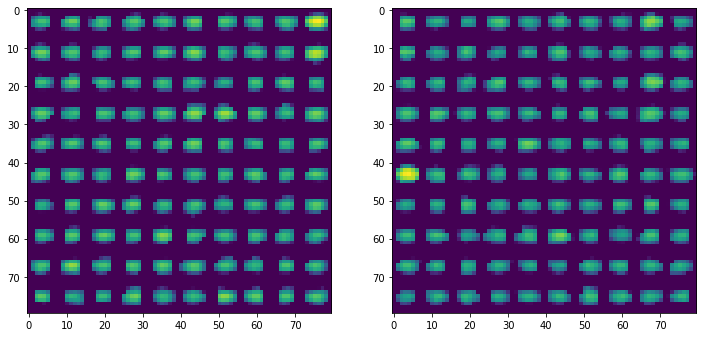

In [452]:
import matplotlib.pyplot as plt

LATENT_DIM = 32

generated_images = generator(tf.random.normal(shape=(N * N, LATENT_DIM)))
draw_imgs(images[:N * N], generated_images.numpy())

In [0]:
import math

def sample_mean(X, weights=None):
    """ X - sample x1, x2, .. xn
    X - np.array
    returns sample mean
    """
    if weights is None:
        weights = np.ones(X.shape)
    return np.sum(X * weights) / np.sum(weights)

def sample_variance(X, weights=None):
    """ X - sample x1, x2, .. xn
    X - np.array
    returns sample varience ** 2
    """
    mean = sample_mean(X, weights)
    if weights is None:
        weights = np.ones(X.shape)
    sqr_variance = np.sum(weights * ((X - mean) ** 2)) / np.sum(weights)
    return math.sqrt(sqr_variance)

def unbiased_sample_variance(X, weights=None):
    """
    https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation
    """
    if weights is None:
        weights = np.ones(X.shape)
    n = np.sum(weights)
    return sample_variance(X, weights) * math.sqrt(n) / math.sqrt(n - 1)

def standard_error(X):
    return math.sqrt(unbiased_sample_variance(X)) / math.sqrt(X.shape[0])

def sample_correlation_coefficient(X, Y):
    """
    X - sample x1, x2, .. xn
    Y - sample y1, y2, .. yn
    X, Y - np.array
    https://en.wikipedia.org/wiki/Correlation_and_dependence
    """
    x_mean, y_mean = sample_mean(X), sample_mean(Y)
    return np.sum((X - x_mean) * (Y - x_mean)) / ((X.shape[0] - 1) * unbiased_sample_variance(X) * unbiased_sample_variance(Y))

def bootstrap(X):
    rand = tf.random.uniform(shape=X.shape, dtype='int32', minval=0, maxval=X.shape[0])
    return tf.gather(X, rand)

In [0]:
def get_max_amplitude(img):
    return np.amax(img)

def get_mean_amplitude(img):
    return np.mean(img)

def get_center(img):
    img = img.reshape((8, 8))
    y_range = np.array(list(map(lambda x: range(0, 8), range(0, 8))))
    x_range = np.transpose(y_range)
    y_mean = sample_mean(y_range, img)
    x_mean = sample_mean(x_range, img)
    return [x_mean, y_mean]

def get_covariance(img):
    img = img.reshape((8, 8))
    y_range = np.array(list(map(lambda x: range(0, 8), range(0, 8))))
    x_range = np.transpose(y_range)
    mu0 = sample_variance(x_range, img)
    mu1 = sample_variance(y_range, img)
    [x_mean, y_mean] = get_center(img)
    cov = sample_variance((x_range - x_mean) * (y_range - y_mean), img)
    return [mu0, mu1, cov]

In [0]:
import seaborn as sns

In [0]:
from scipy.stats import ks_2samp

def get_centers(imgs):
    return np.array(list(map(lambda img: get_center(img), imgs)))

def get_amps(imgs):
    return np.array(list(map(lambda img: get_max_amplitude(img), imgs)))

def get_mean_amps(imgs):
    return np.array(list(map(lambda img: get_mean_amplitude(img), imgs)))

def get_covariances(imgs):
    return np.array(list(map(lambda img: get_covariance(img), imgs)))

def plot_centers(real, generated):
    plt.scatter(real[:, 0], real[:, 1], color='limegreen', s=1)
    plt.scatter(generated[:, 0], generated[:, 1], color='gold', s=1)
    plt.xlabel("Centers distribution\n yellow - generated\n green - original")
    plt.show()

def distplot(real, generated):
    sns.distplot(real, label='real')
    sns.distplot(generated, label='generated')
    pyplot.legend(loc='upper right')
    plt.show() 

def show_mistake(real_dist, generated_dist, name=""):
    print(name)
    real_mean = sample_mean(real_dist)
    generated_mean = sample_mean(generated_dist)
    real_covariance = sample_variance(real_dist)
    ks_2samp(real_dist, generated_dist)
    generated_covariance = sample_variance(generated_dist)
    print("Real mean: ", real_mean, " ∓ ",  standard_error(real_dist))
    print("Generated mean: ", generated_mean, ", Error: ", abs(generated_mean - real_mean))
    print("Real covariance: ", real_covariance, ", Generated covariance: ", generated_covariance)
    print("Kolmogorov–Smirnov test: ", ks_2samp(real_dist, generated_dist)[0] * math.sqrt(len(real_dist) / 2))

def plot_results(real, generated):
    real_centers = get_centers(real)
    generated_centers = get_centers(generated)

    plot_centers(real_centers, generated_centers)

    show_mistake(real_centers[:, 0], generated_centers[:, 0], "X_center")
    show_mistake(real_centers[:, 1], generated_centers[:, 1], "Y_center")

    real_amps = get_amps(real)
    generated_amps = get_amps(generated)

    distplot(real_amps, generated_amps)
    show_mistake(real_amps, generated_amps, "Amplitude")

    real_amps = get_mean_amps(real)
    generated_amps = get_mean_amps(generated)

    distplot(real_amps, generated_amps)
    show_mistake(real_amps, generated_amps, "Amplitude")

    real_cov = get_covariances(real)
    generated_cov = get_covariances(generated)

    for i in range(0, 3):
        distplot(real_cov[:, i], generated_cov[:, i])
        show_mistake(real_cov[:, i], generated_cov[:, i], "Covariance")



In [0]:
random_noise = tf.random.normal(shape=(9982, LATENT_DIM - 1))
model_input = tf.concat([np.expand_dims(angles, axis=1), random_noise], axis=-1)

In [0]:
def plot_centers(real, generated):
    plt.scatter(real[:, 0], real[:, 1], color='limegreen', s=1)
    plt.scatter(generated[:, 0], generated[:, 1], color='gold', s=1)
    plt.show()

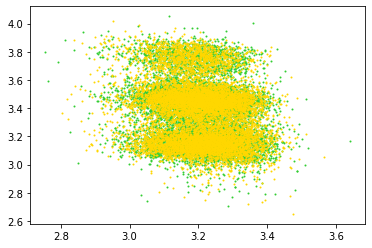

X_center
Real mean:  3.2062615300845727  ∓  0.0031010678635116475
Generated mean:  3.204914051224082 , Error:  0.0013474788604908028
Real covariance:  0.09598831131557542 , Generated covariance:  0.09725573582226787
Kolmogorov–Smirnov test:  1.0616160565726345
Y_center
Real mean:  3.3715540159214457  ∓  0.004657747812076057
Generated mean:  3.368395951067639 , Error:  0.0031580648538067635
Real covariance:  0.21654479616571098 , Generated covariance:  0.21789233280322776
Kolmogorov–Smirnov test:  1.2527069467557086


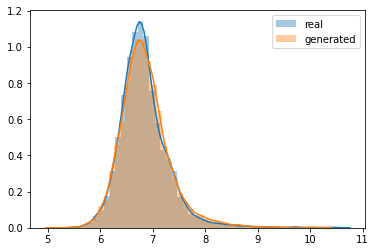

Amplitude
Real mean:  6.840581919256105  ∓  0.006914706049322027
Generated mean:  6.862083345203786 , Error:  0.021501425947680453
Real covariance:  0.47724705343118634 , Generated covariance:  0.47656143048745
Kolmogorov–Smirnov test:  3.1636158485864505


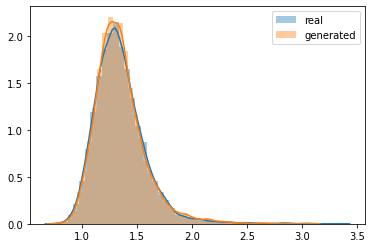

Amplitude
Real mean:  1.3477915816311854  ∓  0.004839492522705469
Generated mean:  1.3484411514717791 , Error:  0.0006495698405937222
Real covariance:  0.23377359575418977 , Generated covariance:  0.22603480494919673
Kolmogorov–Smirnov test:  1.160700221852747


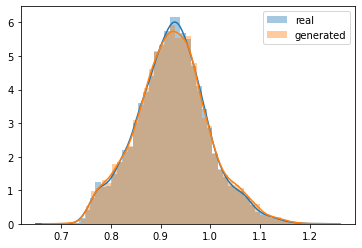

Covariance
Real mean:  0.9229529724237733  ∓  0.0026941564460362484
Generated mean:  0.9237842245084537 , Error:  0.0008312520846803784
Real covariance:  0.07245050760560673 , Generated covariance:  0.07411820314870088
Kolmogorov–Smirnov test:  0.7855958818637494


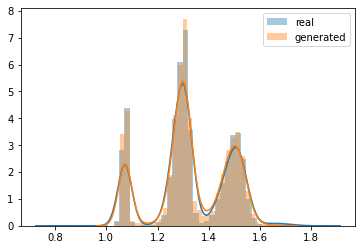

Covariance
Real mean:  1.3311865630922906  ∓  0.0038894463115669606
Generated mean:  1.3306653766913372 , Error:  0.0005211864009533329
Real covariance:  0.15099806175287506 , Generated covariance:  0.1453170340547567
Kolmogorov–Smirnov test:  1.231474625624256


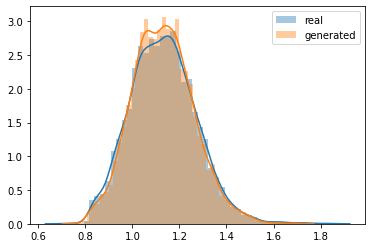

Covariance
Real mean:  1.1312416493539785  ∓  0.003732681631648636
Generated mean:  1.1300945396392494 , Error:  0.0011471097147290887
Real covariance:  0.13907136258296698 , Generated covariance:  0.13045429115382381
Kolmogorov–Smirnov test:  1.3871783139215756


In [459]:
real = images[:9982]
generated = generator(model_input).numpy()

plot_results(real, generated)

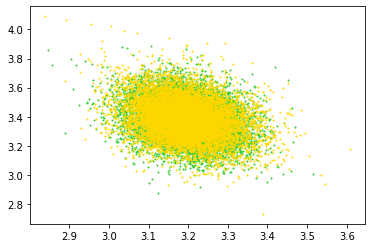

X_center
Real mean:  3.1947116919255425  ∓  0.0027075467368880904
Generated mean:  3.1930398104240516 , Error:  0.0016718815014908905
Real covariance:  0.07317247325987848 , Generated covariance:  0.0771574177084023
Kolmogorov–Smirnov test:  1.6065789656132532
Y_center
Real mean:  3.386559186258276  ∓  0.0035475446324722743
Generated mean:  3.3900380914107693 , Error:  0.0034789051524932724
Real covariance:  0.12561790518721488 , Generated covariance:  0.12777670945032304
Kolmogorov–Smirnov test:  1.5428820022188954


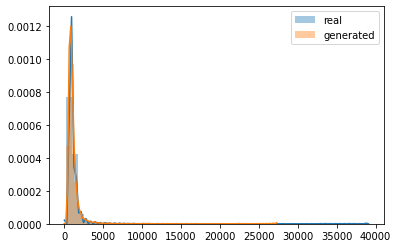

Amplitude
Real mean:  1107.880024043278  ∓  0.37590565575909674
Generated mean:  1105.2573768403242 , Error:  2.622647202953658
Real covariance:  1410.4364748995922 , Generated covariance:  976.200763984729
Kolmogorov–Smirnov test:  3.1636158485864505


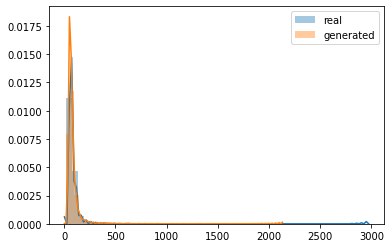

Amplitude
Real mean:  82.62660602835103  ∓  0.1028568422962501
Generated mean:  80.839283291502 , Error:  1.7873227368490348
Real covariance:  105.59957863393502 , Generated covariance:  71.21916137810898
Kolmogorov–Smirnov test:  1.8896765806992892


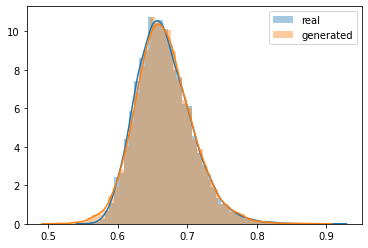

Covariance
Real mean:  0.6667869683681985  ∓  0.001992413379613684
Generated mean:  0.6664151256212479 , Error:  0.00037184274695056807
Real covariance:  0.039623671048030475 , Generated covariance:  0.041070550662049794
Kolmogorov–Smirnov test:  1.1323904603441435


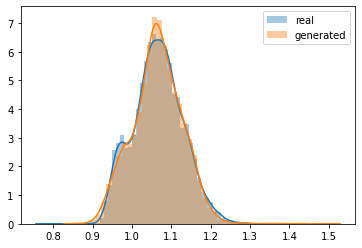

Covariance
Real mean:  1.0656402228218502  ∓  0.0025131662680548035
Generated mean:  1.0646038969265985 , Error:  0.0010363258952517107
Real covariance:  0.06304320074300725 , Generated covariance:  0.06320277803963832
Kolmogorov–Smirnov test:  0.9837642124239745


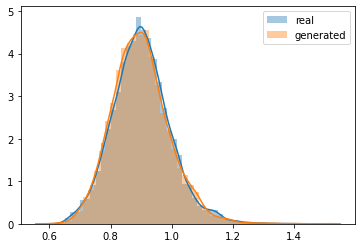

Covariance
Real mean:  0.9009263652933786  ∓  0.0030625503617290385
Generated mean:  0.8982820305895413 , Error:  0.002644334703837292
Real covariance:  0.09361863159152381 , Generated covariance:  0.09337362964699292
Kolmogorov–Smirnov test:  1.8967540210764402


In [460]:
real = np.exp(images[:9982])
generated = np.exp(generated)
plot_results(real, generated)

In [461]:
x_centers, y_centers, mean_amps, max_amps = [], [], [], []
mu0_, mu1_, cov_ = [], [], []

for img in np.exp(images):
  [x_center, y_center] = get_center(img)
  x_centers.append(x_center)
  y_centers.append(y_center)
  mean_amps.append(get_mean_amplitude(img))
  max_amps.append(get_max_amplitude(img))
  [mu0, mu1, cov] = get_covariance(img)
  mu0_.append(mu0)
  mu1_.append(mu1)
  cov_.append(cov)


print(sample_correlation_coefficient(np.array(angles), np.array(x_centers)))
print(sample_correlation_coefficient(np.array(angles), np.array(y_centers)))
print(sample_correlation_coefficient(np.array(angles), np.array(mean_amps)))
print(sample_correlation_coefficient(np.array(angles), np.array(mean_amps)))
print(sample_correlation_coefficient(np.array(angles), np.array(max_amps)))
print(sample_correlation_coefficient(np.array(angles), np.array(mu0_)))
print(sample_correlation_coefficient(np.array(angles), np.array(mu1_)))
print(sample_correlation_coefficient(np.array(angles), np.array(cov_)))

0.007322726348433877
-0.013656649161531337
0.008719018721957017
0.008719018721957017
-0.006252928741713285
0.25868103496237527
0.0169923356001231
0.0604829417995836


In [462]:
gen_x_centers, gen_y_centers, gen_mean_amps, gen_max_amps = [], [], [], []
gen_mu0_, gen_mu1_, gen_cov_ = [], [], []

for img in generated:
  [x_center, y_center] = get_center(img)
  gen_x_centers.append(x_center)
  gen_y_centers.append(y_center)
  gen_mean_amps.append(get_mean_amplitude(img))
  gen_max_amps.append(get_max_amplitude(img))
  [mu0, mu1, cov] = get_covariance(img)
  gen_mu0_.append(mu0)
  gen_mu1_.append(mu1)
  gen_cov_.append(cov)


print(sample_correlation_coefficient(np.array(angles), np.array(gen_x_centers)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_y_centers)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_mean_amps)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_mean_amps)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_max_amps)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_mu0_)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_mu1_)))
print(sample_correlation_coefficient(np.array(angles), np.array(gen_cov_)))

0.014656526252033963
0.00037738759413806
-0.04462713563749453
-0.04462713563749453
-0.06352357979376463
0.21442952256585052
0.03262899504803741
0.04565003343239828


In [463]:
generated_covariances = get_covariances(generated)[:, 0]
real_covariances = get_covariances(real)[:, 0]
print(sample_correlation_coefficient(angles, generated_covariances))
print(sample_correlation_coefficient(angles, real_covariances))

0.21442952256585052
0.25868103496237527


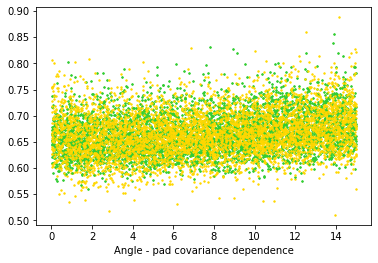

In [464]:
plt.scatter(angles[:2000], generated_covariances[:2000], s=2,  color='gold')
lo = plt.scatter(angles[:4000], real_covariances[:4000], s=2, color='limegreen', marker='X')
plt.scatter(angles[4000:8000], generated_covariances[4000:8000], s=2,  color='gold')
plt.xlabel("Angle - pad covariance dependence")
plt.show()

In [0]:
generated_x = get_centers(generated)[:, 0]
real_x = get_centers(real)[:, 0]

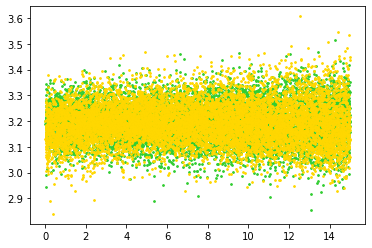

In [466]:
plt.scatter(angles[:9900], real_x[:9900], s=3, color='limegreen')
plt.scatter(angles[:9900], generated_x[:9900], s=3, color='gold')
plt.show()